# Inleiding

Voor deze opdracht gaan jullie zelf op zoek naar je eigen dataset. De dataset bevat in ieder geval een kolom met een timestamp (een datum of een tijdstip) met gelijke stapgrootte (uurlijkse/dagelijkse/jaarlijkse data). Daarnaast komt deze tijdaanduiding minstens 36x terug, dus bij het gebruik van maanden minstens 36 maanden. Liever heb je een dataset die groot genoeg is om de train/test splitsing logisch te maken. Denk aan een seizoenseffect dat pas eind van elk jaar gebeurt: dan zou je je testset niet de laatste paar maanden van dat jaar zijn, omdat het zo anders van je trainset zou zijn. 

Let op: In tegenstelling tot de eerste opdracht, voor deze en de resterende 1 opdracht worden jullie peer reviews alleen beoordeeld op een ja of nee basis. 

Zoals geschreven in de vakbeschrijving:

"Het niet op tijd of lui maken van een individuele peer review resulteert in een reductie van 0,5 punt voor het cijfer van de bijhorende opdracht van de reviewer."

Gezien dat jullie peer reviews zijn sowieso kwalitatief beoordeeld voor Opdracht 1, is deze halfpunt reductie alleen voor Opdrachten 2 t/m 4 geldig. 

### Algemene Coderen Conventies

De volgorde van het python script is belangrijk. Zo zorg je bijvoorbeeld altijd dat eerst de benodigde packages worden ingeladen geïnstalleerd en geïmporteerd). Verder is het goed om van tevoren jouw working directory te controleren. 

Schrijf het python script daarom met een duidelijke indeling van met verschillende stappen. Bij elke stap dient toelichting worden gegeven:
1. Wat is het doel van deze stap?
2. Wat is de input van deze stap?
3. Wat is de output van deze stap en waar heb je deze output hierna nog nodig?

Hieronder voorbeelden van de verschillende punten hierboven.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet

# Theorievragen

Beantwoord voordat je met de dataset aan de slag gaan, eerst de volgende vragen:

Dit is wat er nodig is voor de hoogste score volgens de beoordelingsrubriek:

"Heeft de theorie vragen beantwoord en de uitleg is begrijpelijk en er worden voorbeelden bij gehaald. De uitleg wordt ondersteund door visualisaties. Ook wordt autocorrelatie beschreven bij de uiteindelijke modellen."

Wat is autocorrelatie?

Let het verschil uit tussen een AR model en een MA model.

Hoe werkt een ARIMA model om deze twee methoden te combineren en wat doet het "I" element?

Geef een korte uitleg over de techniek Exponential Smoothing.

# Deelopdracht 1/3 - Dataverkenning

Splits de data op in een train en test dataset. De traindataset mag niet te klein zijn. Doe de splitsing op chronologische volgorde. Bij bijvoorbeeld januari tot en met december, zouden november en december de testdataset zijn (je kan alleen vooruit in de tijd).

Dit is wat er nodig is voor de hoogste score volgens de beoordelingsrubriek:

"Heeft verkennende plots gemaakt. Heeft datatype van tijdsvariabele correct behandeld en gekeken of de tijdreeks geen gaten heeft. Daarnaast is er een goede analyse van trend, seizoenspatronen en autocorrelatie gemaakt. De gevonden patronen worden bediscussieerd en er worden mogelijke verklaringen/interpretaties voor gegeven."

Gekozen dataset: https://www.kaggle.com/datasets/rprkh15/sp500-stock-prices?select=A.csv

In [7]:
data = pd.read_csv('A.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5697 entries, 0 to 5696
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          5697 non-null   object 
 1   Open          5697 non-null   float64
 2   High          5697 non-null   float64
 3   Low           5697 non-null   float64
 4   Close         5697 non-null   float64
 5   Volume        5697 non-null   int64  
 6   Dividends     5697 non-null   float64
 7   Stock Splits  5697 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 356.2+ KB


Om een échte Timeseries-dataset te gaan maken, moeten we ervoor zorgen dat de datum kolom van type Datetime is en vervolgens als index gezet wordt.

In [8]:
data['Date'] = pd.to_datetime(data['Date'])
data.dtypes

Date            datetime64[ns]
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                   int64
Dividends              float64
Stock Splits           float64
dtype: object

In [9]:
data.set_index('Date', inplace=True)
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1999-11-18,27.896016,30.654965,24.523970,26.976368,62546380,0.0,0.0
1999-11-19,26.324950,26.363270,24.409017,24.753885,15234146,0.0,0.0
1999-11-22,25.328663,26.976368,24.562289,26.976368,6577870,0.0,0.0
1999-11-23,26.056724,26.746461,24.523975,24.523975,5975611,0.0,0.0
1999-11-24,24.600619,25.711862,24.523981,25.175400,4843231,0.0,0.0


In [10]:
data.index.year.unique()

Index([1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
      dtype='int32', name='Date')

Hier kunnen we zien dat de dataset van 1999 loopt naar 2022(in dagen)

In [11]:
data.resample('1d').mean().loc[data.resample('1d').mean().isna()['High']]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1999-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-11-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-11-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-11-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-11-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2022-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Er zijn 2576 dagen met missende waarden

In [12]:
data.loc['2022-07']

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-07-01,118.790001,119.760002,116.699997,119.209999,1119800,0.21,0.0
2022-07-05,117.750000,120.680000,116.489998,120.559998,1484900,0.00,0.0
2022-07-06,120.800003,122.339996,120.559998,121.180000,1642300,0.00,0.0
2022-07-07,120.989998,123.220001,120.620003,123.150002,1221200,0.00,0.0
2022-07-08,120.959999,123.209999,120.959999,122.510002,1267300,0.00,0.0
2022-07-11,121.610001,123.459999,121.010002,123.120003,1304400,0.00,0.0
2022-07-12,122.430000,123.410004,118.750000,119.239998,1196800,0.00,0.0


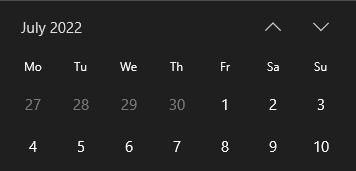
4 Juli: Independence Day

De reden waarom er geen datapunten zijn op deze dagen is dat de aandelenmarkt dicht zijn in het weekend en andere feestdagen

In [13]:
data_filled = data.resample('1d').ffill()
data_filled.loc[data_filled['High'].isna()]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,


Om een chronologische structuur te behouden, gaan we de missende dagen opvullen met behulp van de Forward Fill methode (pakt de waardes van de vorige waarneming).

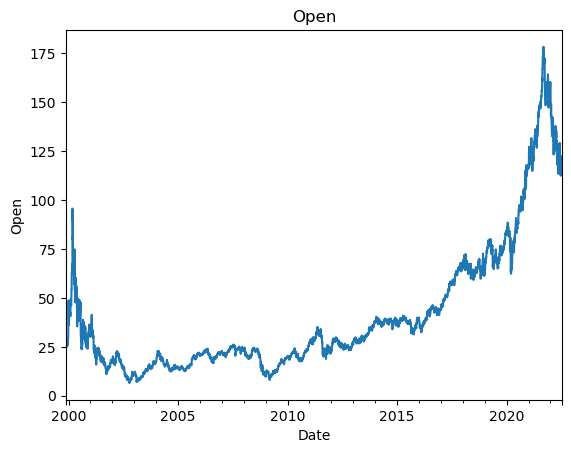

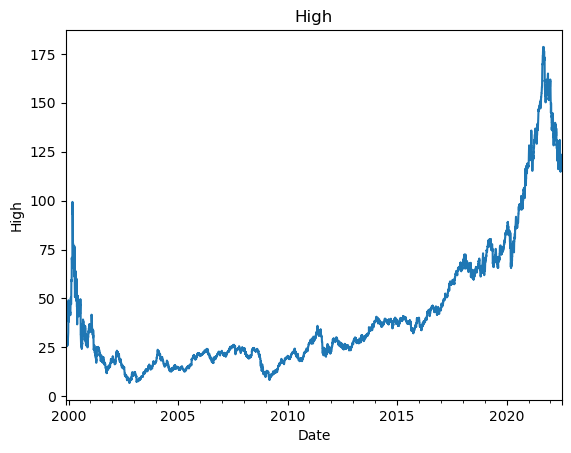

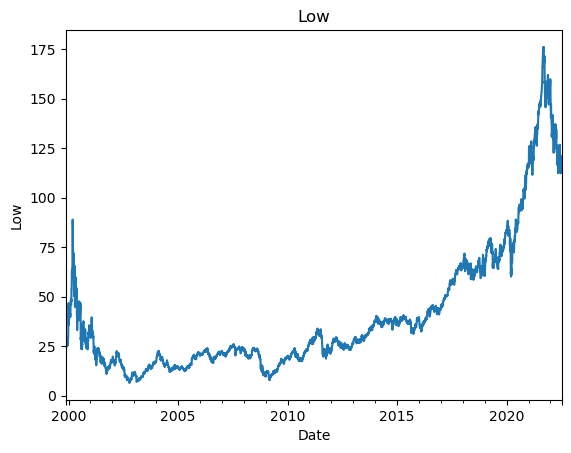

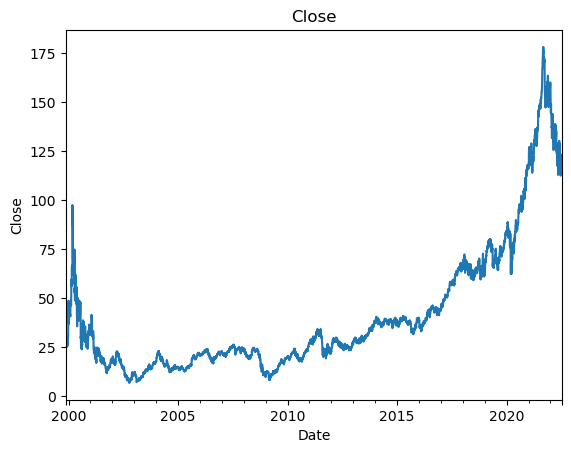

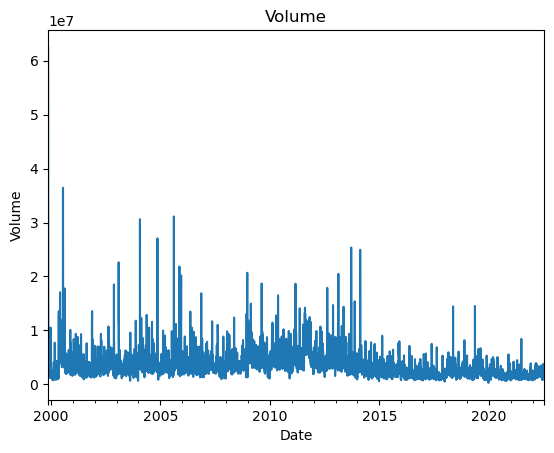

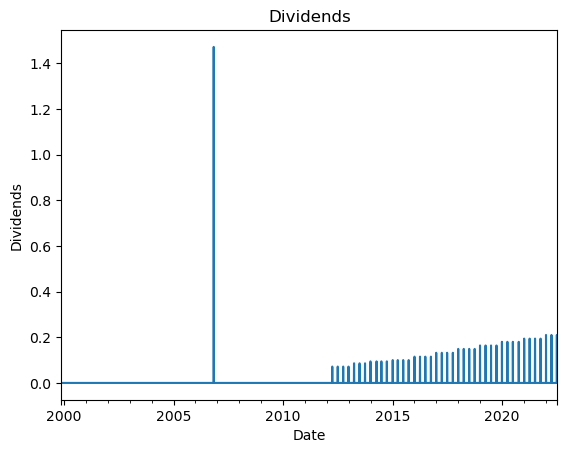

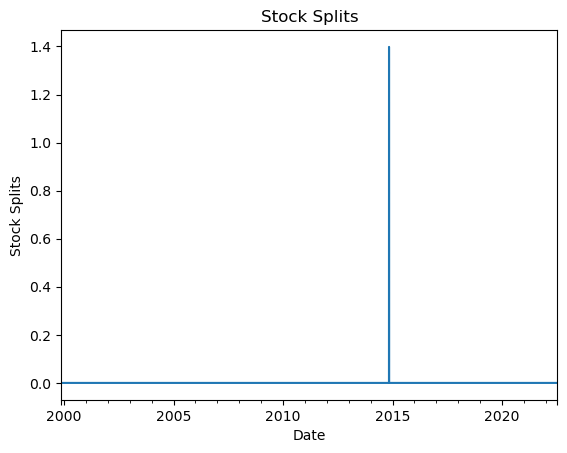

In [12]:
for column in data_filled.columns:
    data_filled[column].plot()
    plt.title(column)
    plt.ylabel(column)
    plt.show()


Voer een uitgebreidere dataverkenning uit (volgens de beschrijving hierboven uit de beoordelingsrubriek) op jullie gekozen dataset. Gebruik zoveel cellen als nodig, maar liever alleen plotjes/prints maken die echt een impact op jullie modellen gaan maken (samen met uitleg tekst van wat jullie daarmee opvalt).  

* High = Hoogste waarde van het aandeel op een dag
* Low = Laagste waarde van het aandeel op een dag
* Open = Waarde van het aandeel aan het begin van de dag
* Close = Waarde van het aandeel aan het eind van de dag

Deze waarden zullen ongeveer dezelfde uitzien in een grafiek, daarom hebben we gekozen om er 1 van te maken.

In [14]:
data_filled['Avg'] = (data_filled['High'] + data_filled['Low'])/2 # Gemiddelde waarde per dag
data_filtered = data_filled.drop(['High', 'Low', 'Open', 'Close'], axis=1)

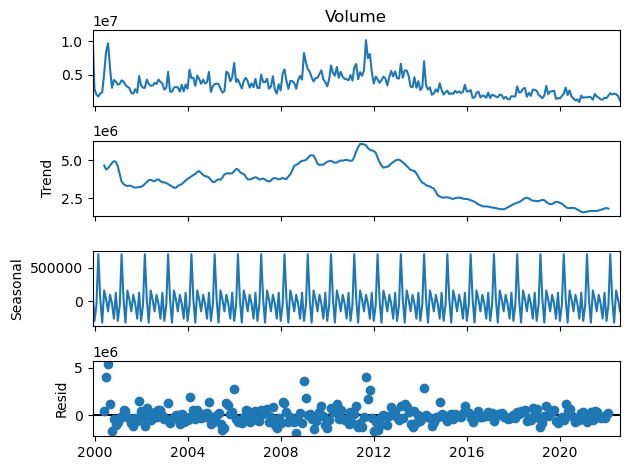

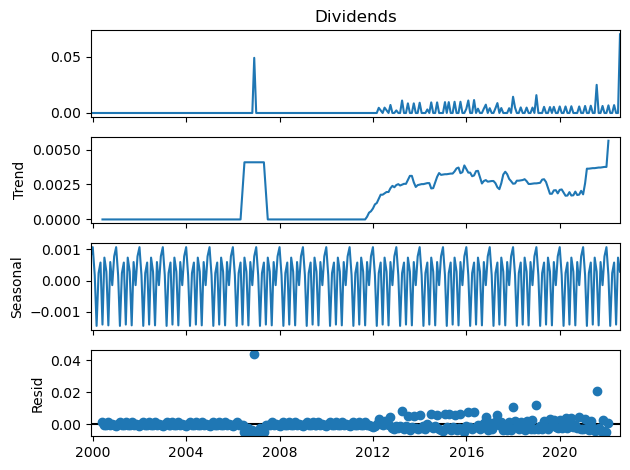

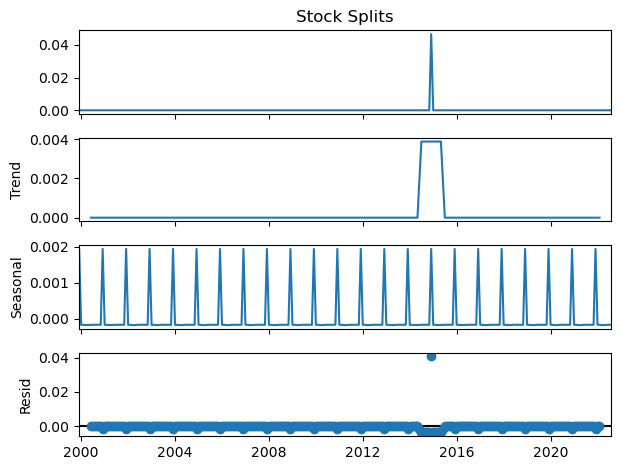

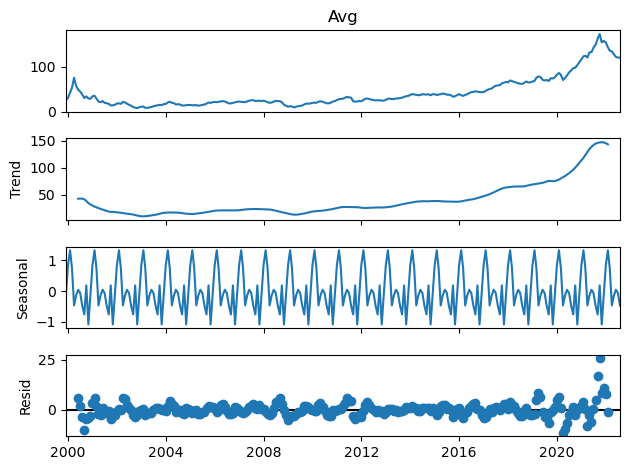

In [14]:
for column in data_filtered.columns:
    monthly = data_filtered[column].resample('ME').mean() # Inzoomen op maanden
    result = seasonal_decompose(monthly, model='additive', period=12)
    result.plot()
    
plt.show()

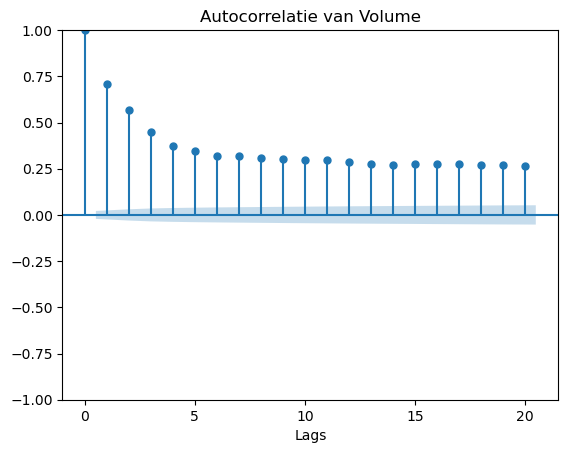

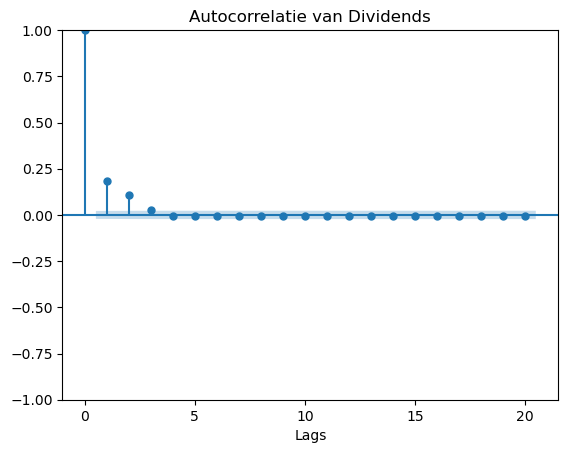

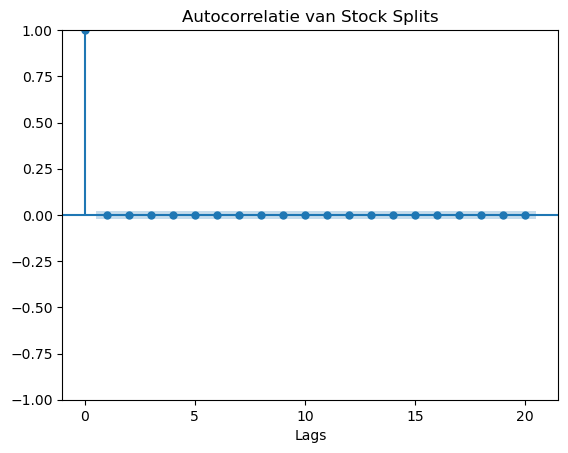

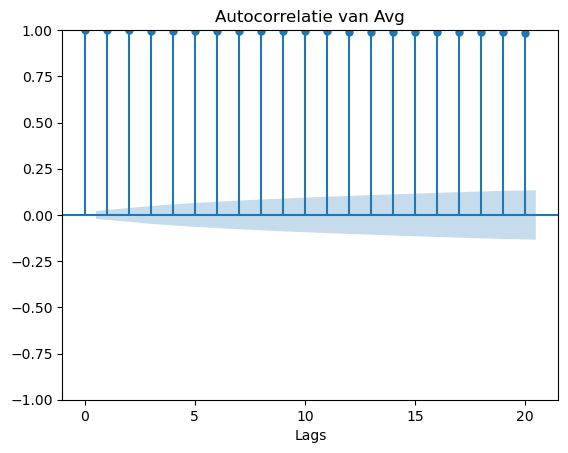

In [15]:
for column in data_filtered.columns:
    plot_acf(data_filtered[column], lags=20)
    plt.title(f'Autocorrelatie van {column}')
    plt.xlabel('Lags')
plt.show()

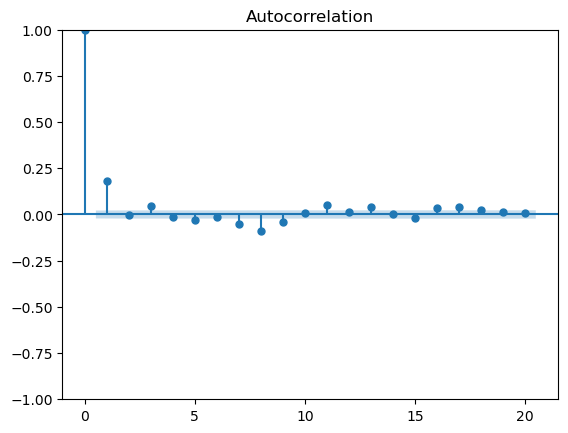

In [16]:
# We moeten eerst 'Differencing' gaan toepassen op onze data omdat het niet stationary blijkt te zijn
df_diff = data_filled['Avg'].diff().dropna()

plot_acf(df_diff, lags=20)
plt.show()

Is er een trend zichtbaar in de data? Wat walt je hier op?

Voor meeste kolommen wel, behalve 'Dividend' en 'Stock Splits' (waarschijnlijk omdat het niet regelmatig gaat voorkomen). De trend gaat vanaf 2012 blijven stijgen tot aan 2022.

Is er een seizoenspatroon zichtbaar in de data? Wat valt je hier op?

Ja, er is een sprake van een cyclus dat zich steeds herhaalt, de pieken zijn aan het begin van het jaar en zullen blijven dalen tot April/Mei.

Zit er autocorrelatie in de data? Wat valt je hier op?

Ja, vergelijkbaar met de trend: alleen Dividend en Stock Splits hebben geen Autocorrelatie, bij andere kolommen liggen een aantal datapunten boven of onder de confidence interval (lichtblauw gemarkeerd).

## Train en test dataset

In [52]:
data_filtered = data_filtered.sort_index() # Sorteren op chronologische volgorde voor de zekerheid
X_train, X_test = data_filtered.loc[:'2018'][['Avg']], data_filtered.loc['2019':][['Avg']] # We zetten hier de afkappunt bij 2018
print(f'Lengte van Train: {len(X_train)}, lengte van test: {len(X_test)}')

Lengte van Train: 6984, lengte van test: 1289


# Deelopdracht 2/3 - Prophet Package

Maak een voorspelling met het Prophet package.

Gebruik ‘conda install -c conda-forge prophet’ 

Check even de installatie instructies op deze pagina: https://facebook.github.io/prophet/docs/quick_start.html

Dit is wat er nodig is voor de hoogste score volgens de beoordelingsrubriek:

"De voorspelling met het Prophet package is correct uitgevoerd en uitgebreid beschreven. De prestatiemetrics worden op train en test berekend. Er wordt geëxperimenteerd met verschillende instellingen."

Visualiseer de voorspelling.

In [67]:
df = data_filtered.copy().reset_index()[['Date', 'Avg']]
df.head()

,Date,Avg
0,1999-11-18,27.589468
1,1999-11-19,25.386143
2,1999-11-20,25.386143
3,1999-11-21,25.386143
4,1999-11-22,25.769328


In [68]:
df_prophet = df.rename(columns={'Date': 'ds', 'Avg': 'y'})
df_prophet.head()

,ds,y
0,1999-11-18,27.589468
1,1999-11-19,25.386143
2,1999-11-20,25.386143
3,1999-11-21,25.386143
4,1999-11-22,25.769328


18:14:54 - cmdstanpy - INFO - Chain [1] start processing
18:14:58 - cmdstanpy - INFO - Chain [1] done processing


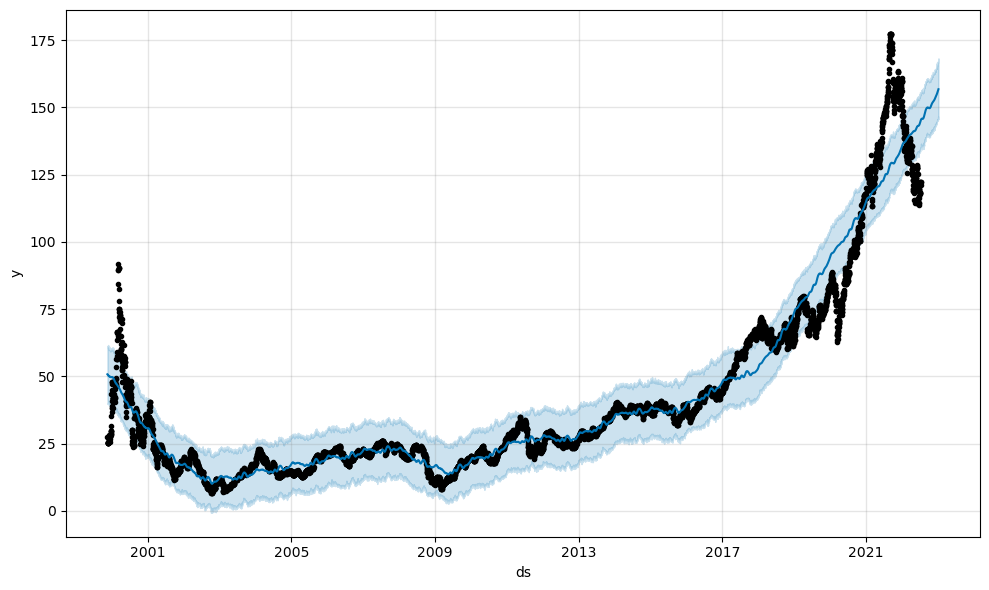

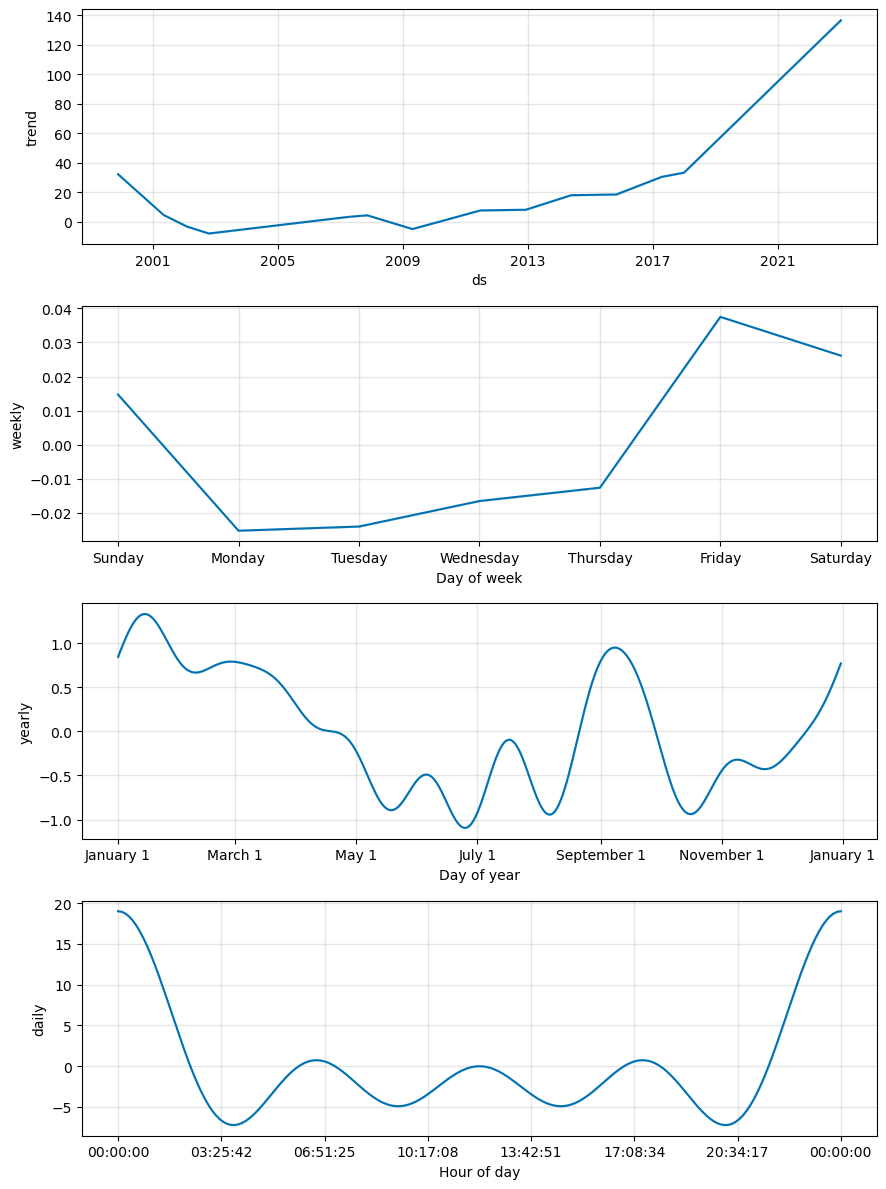

In [69]:
# Maak en train het model
model = Prophet(daily_seasonality=True)
model.fit(df_prophet)

# Voorspel 180 dagen vooruit
future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)

# Plot resultaten
fig1 = model.plot(forecast)
fig2 = model.plot_components(forecast)


Wat valt je op?

De Prophet-plots tonen een duidelijke trend in de slotprijs, met voorspellingen die goed aansluiten op de historische data op korte termijn. De onzekerheidsmarge neemt toe naarmate de voorspelling verder de toekomst in gaat. In de componentenplot zie je een geleidelijke trend en een herkenbaar wekelijks patroon, waarbij sommige dagen structureel hoger of lager liggen. Jaarlijkse patronen zijn minder duidelijk aanwezig, wat logisch is bij beperkte historische data. Over het geheel geeft Prophet een helder beeld van de langetermijntrend, maar vangt het minder goed plotselinge schommelingen in aandelenkoersen.

Bereken een kwaliteitsmaat (bijvoorbeeld RMSE of MAE) op de train- en testdataset.

In [70]:
# Split 80/20
split_index = int(len(df_prophet) * 0.8)
train = df_prophet.iloc[:split_index]
test = df_prophet.iloc[split_index:]

In [71]:
model = Prophet(daily_seasonality=True)
model.fit(train)

18:15:08 - cmdstanpy - INFO - Chain [1] start processing
18:15:11 - cmdstanpy - INFO - Chain [1] done processing


In [72]:
# Lengte testset bepaalt hoeveel dagen vooruit we voorspellen
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)


In [73]:
# Train/test split
split_index = int(len(df_prophet) * 0.8)
train = df_prophet.iloc[:split_index]
test = df_prophet.iloc[split_index:]

# Prophet model trainen op de trainset
model = Prophet(daily_seasonality=True)
model.fit(train)

# Voorspel tot en met de laatste datum in testset
last_date = test['ds'].max()
future = model.make_future_dataframe(periods=0)  # geen extra rijen toevoegen
future = pd.concat([future, test[['ds']]])      # voeg testdatums expliciet toe
future = future.drop_duplicates().sort_values('ds')

# Voorspellen
forecast = model.predict(future)

# Merge echte testwaarden met voorspelde waarden (op datum)
merged = pd.merge(test, forecast[['ds', 'yhat']], on='ds')

# Bereken MAE en RMSE
mae = mean_absolute_error(merged['y'], merged['yhat'])
rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))

print(f"MAE (test):  {mae:.2f}")
print(f"RMSE (test): {rmse:.2f}")



18:15:16 - cmdstanpy - INFO - Chain [1] start processing
18:15:20 - cmdstanpy - INFO - Chain [1] done processing


MAE (test):  27.22
RMSE (test): 37.44


In [74]:
# Bereken op trainingset
forecast_train = model.predict(train)
merged_train = pd.merge(train, forecast_train[['ds', 'yhat']], on='ds')

mae_train = mean_absolute_error(merged_train['y'], merged_train['yhat'])
rmse_train = np.sqrt(mean_squared_error(merged_train['y'], merged_train['yhat']))

print(f"MAE (train):  {mae_train:.2f}")
print(f"RMSE (train): {rmse_train:.2f}")


MAE (train):  3.04
RMSE (train): 4.53


Wat valt je hier op?

De MAE en RMSE op de trainingsset zijn relatief laag, wat aangeeft dat het Prophet-model de historische koersgegevens goed heeft leren volgen. Op de testset liggen deze fouten echter wat hoger, wat wijst op een iets mindere generalisatie naar nieuwe, niet eerder geziene data. Dit kan te maken hebben met lichte overfitting of onverwachte koersbewegingen in de testperiode, die Prophet – als trendgericht model – moeilijker kan opvangen. Het feit dat de RMSE hoger is dan de MAE suggereert bovendien dat er enkele grotere voorspelfouten zijn, mogelijk veroorzaakt door abrupte marktbewegingen die niet door de trend- of seizoenscomponenten worden verklaard.

# Deelopdracht 3/3 - Gekozen Model

Maak een voorspelling met het statsmodels package op de traindataset. Kies een optie uit de volgende opties:

1. AR model
2. MA model <--------------
3. ARIMA
4. Exponential Smoothing

Zie deze link voor meer informatie: https://www.statsmodels.org/stable/user-guide.html#time-series-analysis

Dit is wat er nodig is voor de hoogste score volgens de beoordelingsrubriek:

"De voorspelling met het statsmodels package is correct uitgevoerd en uitgebreid beschreven. De prestatiemetrics worden op train en test berekend. Er wordt geëxperimenteerd met verschillende instellingen en de verschillen met de resultaten uit het prophet package worden bediscussieerd."

Visualiseer de voorspelling.

In [75]:
model = ARIMA(X_train, order=(0, 1, 2))  # p=0 (geen AR), d=1 (first difference), q=2 (startpunt volgens lags)
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                    Avg   No. Observations:                 6984
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -6671.489
Date:                Sat, 14 Jun 2025   AIC                          13348.979
Time:                        18:16:21   BIC                          13369.533
Sample:                    11-18-1999   HQIC                         13356.062
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2445      0.004     63.479      0.000       0.237       0.252
ma.L2         -0.0071      0.005     -1.451      0.147      -0.017       0.003
sigma2         0.3957      0.001    463.761      0.0

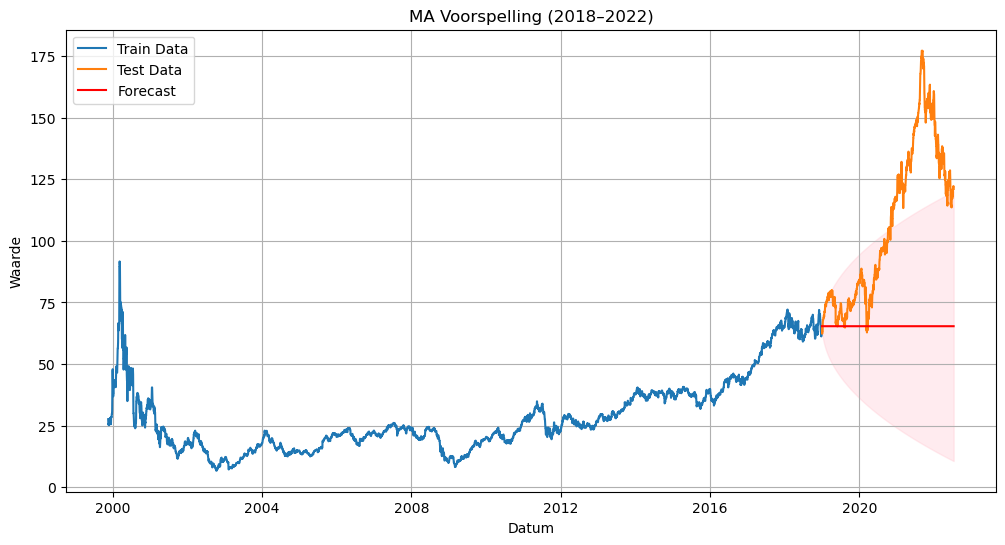

In [76]:
n_test = len(X_test)
forecast = result.get_forecast(steps=n_test)
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(12,6))
plt.plot(X_train.index, X_train, label='Train Data')
plt.plot(X_test.index, X_test, label='Test Data')
plt.plot(pred_mean.index, pred_mean, label='Forecast', color='red')

# Confidence interval
plt.fill_between(pred_mean.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='pink', alpha=0.3)

plt.title('MA Voorspelling (2018–2022)')
plt.xlabel('Datum')
plt.ylabel('Waarde')
plt.legend()
plt.grid(True)
plt.show()

Wat valt je hier op?

(Markdown cell voor uitleg)

Bereken dezelfde kwaliteitsmaat (bijvoorbeeld RMSE of MAE) als bij de Prophet package hierboven op de train- en testdataset.

In [77]:
n_train = len(X_train)
forecast = result.get_forecast(steps=n_train)
pred_mean_train = forecast.predicted_mean

rmse_train = np.sqrt(mean_squared_error(X_train, pred_mean_train))
print("RMSE(Train):", rmse_train)

rmse_test = np.sqrt(mean_squared_error(X_test, pred_mean))
print("RMSE(Test):", rmse_test)

RMSE(Train): 39.69108575297849
RMSE(Test): 52.119451764185655


Vergelijk de voorspellingen (dus van de Prophet package en hier met jullie gekozen model). Welke van de twee komt het meest overeen met de testdataset?

De voorspellingen van ons MA model heeft een slechtere prestatie op de testdataset, dus de Prophet model is in dit geval beter.

Voor welke van de twee modellen zou je kiezen als je echt een voorspelling zou doen? Mochten beiden niet goed werken, wat voor ander model zou je dan proberen?

In ons geval blijkt Prophet toch de betere keuze aangezien die een veel lagere RMSE-waarde heeft, maar misschien kan de ARIMA model een betere prestatie opleveren aangezien die iets meer complex is.

Wat kan je zeggen over autocorrelatie in je definitieve model? 

In [ ]:
(code cell)

(Markdown cell voor uitleg)